## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Урок 4. Image Segmentation

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### 1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# dst_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/archive.zip"

In [7]:
# from zipfile import ZipFile
# zipfile = ZipFile(dst_path)
# zipfile.extractall()

### Step 1
### Starter: Makeup. Lips Segmentation.

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [9]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [10]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [11]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# list.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('E:/set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)
# df1 = pd.read_csv('/content/set-lipstick-original/list.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 9 columns


In [12]:
df1.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [13]:
df1.tail(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
995,image00000996.jpg,1280,720,Lips,692,343,780,412,mask00000996.png
996,image00000997.jpg,1280,720,Lips,620,348,712,402,mask00000997.png
997,image00000998.jpg,1280,720,Lips,700,337,788,405,mask00000998.png
998,image00000999.jpg,1280,720,Lips,679,337,762,389,mask00000999.png
999,image00001000.jpg,1280,720,Lips,667,359,749,412,mask00001000.png


In [14]:
plotPerColumnDistribution(df1, 10, 5)

<Figure size 2400x512 with 0 Axes>

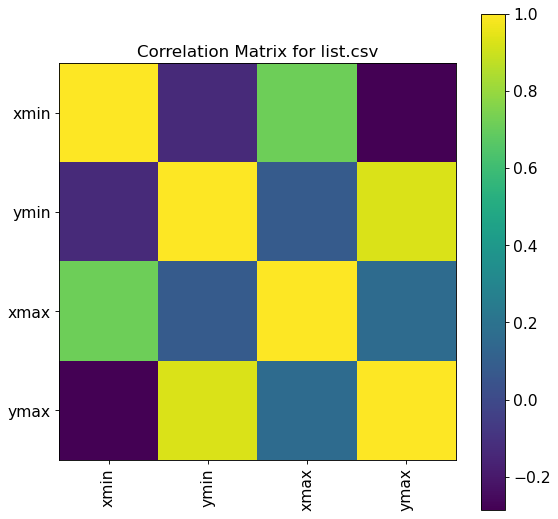

In [15]:
plotCorrelationMatrix(df1, 8)

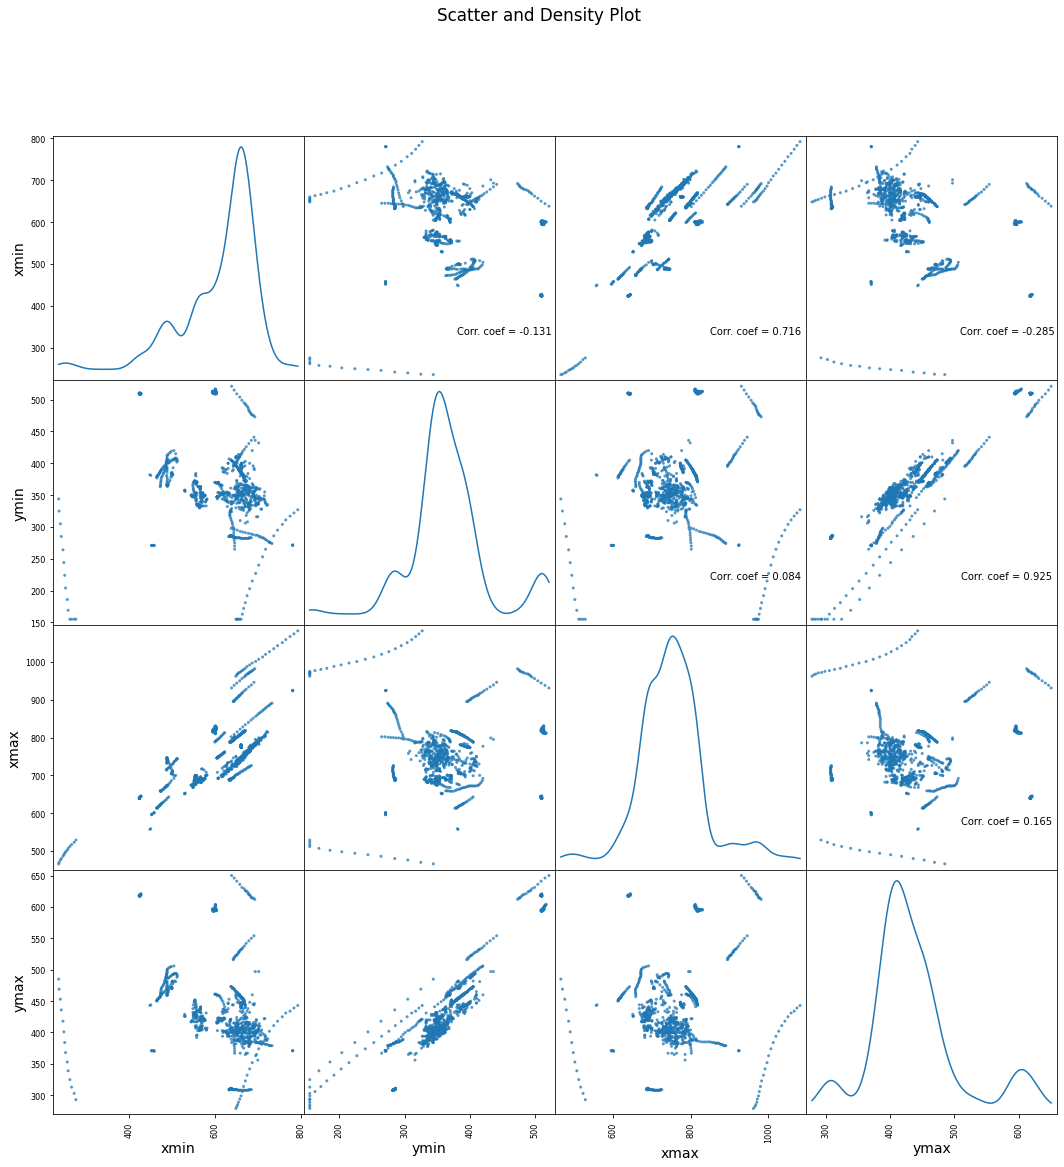

In [16]:
plotScatterMatrix(df1, 18, 10)

### Step 2

In [17]:
# path_image = "/content/set-lipstick-original/720p"
# path_mask = "/content/set-lipstick-original/mask"
path_image = "E:/set-lipstick-original/720p/"
path_mask = "E:/set-lipstick-original/mask/"

In [18]:
labels = ['NoLips','Lips']

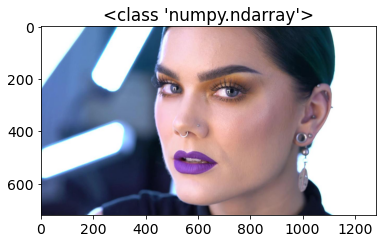

In [19]:
image12069 = plt.imread(path_image+'/image00012069.jpg')

fig, ax = plt.subplots()

ax.imshow(image12069)
ax.set_title(type(image12069))

# fig.set_figwidth(7)    #  ширина и
# fig.set_figheight(7)    #  высота "Figure"

plt.show()

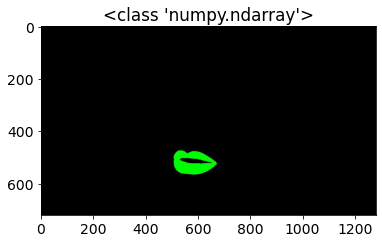

In [20]:
image12069 = plt.imread(path_mask+'/mask00012069.png')

fig, ax = plt.subplots()

ax.imshow(image12069)
ax.set_title(type(image12069))

# fig.set_figwidth(7)    #  ширина и
# fig.set_figheight(7)    #  высота "Figure"

plt.show()

In [21]:
images = []

for root, dirs, files in os.walk(path_image):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            images.append(f)
        else:
            break

In [22]:
masks = []

for root, dirs, files in os.walk(path_mask):
    for name in files:
        f = os.path.join(root, name)
        if 'mask' in f:
            masks.append(f)
        else:
            break

In [23]:
len(images), len(masks), images[-1], masks[-1]

(28594,
 28540,
 'E:/set-lipstick-original/720p/image00028594.jpg',
 'E:/set-lipstick-original/mask/mask00028594.png')

In [24]:
images[0], masks[0]

('E:/set-lipstick-original/720p/image00000001.jpg',
 'E:/set-lipstick-original/mask/mask00000001.png')

In [25]:
images[0][-12:-4], masks[0][-12:-4]

('00000001', '00000001')

In [26]:
images_w_mask = []

for img in images:
    for mask in masks:
        if img[-12:-4] == mask[-12:-4]:
            images_w_mask.append(img)
            break

In [27]:
masks_adapt = []

for img in images_w_mask:
    masks_adapt.append(f"E:/set-lipstick-original/mask/mask{img[-12:-4]}.png")

In [28]:
len(images_w_mask), len(masks_adapt), images_w_mask[-1], masks_adapt[-1]

(28540,
 28540,
 'E:/set-lipstick-original/720p/image00028594.jpg',
 'E:/set-lipstick-original/mask/mask00028594.png')

In [29]:
images_w_mask[7777], masks_adapt[7777]

('E:/set-lipstick-original/720p/image00007778.jpg',
 'E:/set-lipstick-original/mask/mask00007778.png')

In [30]:
df = pd.DataFrame({'images': images_w_mask, 'masks': masks_adapt})
# df = pd.DataFrame({'images': images, 'masks': masks}) - ValueError: arrays must all be same length
# Отсортируем  датафрейм по значениям
df.sort_values(by='images', inplace=True)
# Используем функцию, благодаря которой индексация значений будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые 5 значений нашего датафрейма
print(df.head(5))

                                            images  \
0  E:/set-lipstick-original/720p/image00000001.jpg   
1  E:/set-lipstick-original/720p/image00000002.jpg   
2  E:/set-lipstick-original/720p/image00000003.jpg   
3  E:/set-lipstick-original/720p/image00000004.jpg   
4  E:/set-lipstick-original/720p/image00000005.jpg   

                                            masks  
0  E:/set-lipstick-original/mask/mask00000001.png  
1  E:/set-lipstick-original/mask/mask00000002.png  
2  E:/set-lipstick-original/mask/mask00000003.png  
3  E:/set-lipstick-original/mask/mask00000004.png  
4  E:/set-lipstick-original/mask/mask00000005.png  


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  28540 non-null  object
 1   masks   28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


### Step 3

In [32]:
img = np.asarray(Image.open(images_w_mask[0])).astype('float')
img.shape

(720, 1280, 3)

In [33]:
img = torch.as_tensor(img)/255
img = img.unsqueeze(0)
print(img.shape)
img = img.permute(0,3,1,2)
print(img.shape)
img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
print(img.shape)

torch.Size([1, 720, 1280, 3])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 256, 256])


In [34]:
mask_it = np.asarray(Image.open(masks_adapt[-1])).astype('int')
mask_it.shape

(720, 1280, 3)

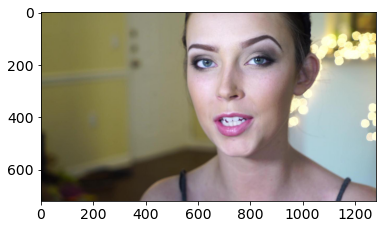

In [35]:
plt.imshow(Image.open(images_w_mask[-1]))

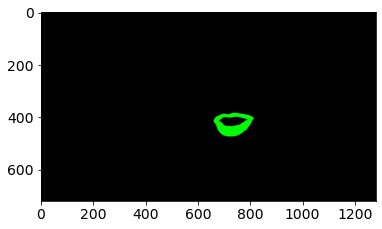

In [36]:
plt.imshow(mask_it)

In [37]:
masks_adapt[-1]

'E:/set-lipstick-original/mask/mask00028594.png'

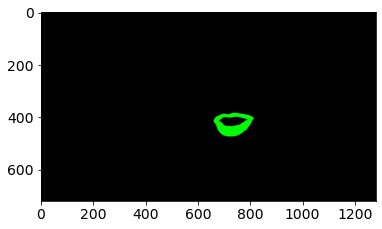

In [38]:
plt.imshow(Image.open('E:/set-lipstick-original/mask/mask00028594.png'))

In [39]:
df1 = pd.read_csv('E:/set-lipstick-original/list.csv', delimiter=',')
df1.dataframeName = 'list.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 28594 rows and 9 columns


In [40]:
df1.tail(1)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png


In [41]:
min(mask_it[mask_it>0]), max(mask_it[mask_it>0]), np.mean(mask_it[mask_it>0])

(1, 255, 83.65212910672328)

In [42]:
mask_it[mask_it[:, :, 1]>0]

array([[0, 1, 4],
       [0, 1, 2],
       [0, 1, 4],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [43]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1] #.astype('int')
lab.shape

(720, 1280)

In [44]:
min(lab[lab>0]), max(lab[lab>0]), np.mean(lab[lab>0])

(0.003921569, 1.0, 0.6849324)

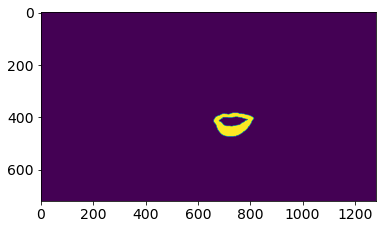

In [45]:
lab[lab>0.4] = 255
plt.imshow(lab)

In [46]:
lab_2 = np.asarray(Image.open(masks_adapt[-1]))[:,:,1]
lab_2.shape

(720, 1280)

In [47]:
min(lab_2[lab_2>0]), max(lab_2[lab_2>0]), np.mean(lab_2[lab_2>0])

(1, 255, 174.65775201047316)

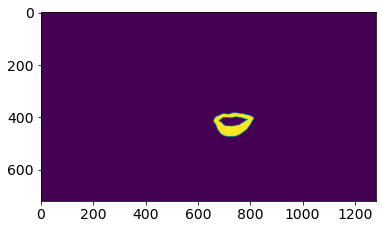

In [48]:
plt.imshow(lab_2)

In [49]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1] #.astype('int')
lab.shape

(720, 1280)

In [50]:
lab[lab<0.4] = 0
lab[lab>=0.4] = 1

In [51]:
min(lab[lab>0]), max(lab[lab>0]), np.mean(lab[lab>0])

(1.0, 1.0, 1.0)

In [52]:
lab = torch.as_tensor(lab)
print(lab.shape)
lab = lab.unsqueeze(0).unsqueeze(0)
print(lab.shape)
lab = F.interpolate(input=lab, size=256, mode='nearest')
print(lab.shape)

torch.Size([720, 1280])
torch.Size([1, 1, 720, 1280])
torch.Size([1, 1, 256, 256])


In [53]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1]

f_lp = np.where(lab<0.4, 255, 0)
t_lp = np.where(lab>=0.4, 255, 0)

f_lp.shape, t_lp.shape

((720, 1280), (720, 1280))

In [54]:
df1.tail(1)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
28593,image00028594.jpg,1280,720,Lips,657,381,817,476,mask00028594.png


In [55]:
f_lp[381:476, 657:817]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [56]:
t_lp[381:476, 657:817]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
lab = np.asarray(plt.imread(masks_adapt[-1]))[:,:,1]

f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)

t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')
lab.shape

torch.Size([1, 2, 256, 256])

In [58]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 720х1280 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (720, 1280, 3) -> (1, 720, 1280, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 720, 1280, 3) -> (1, 3, 720, 1280)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 1280х720 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,1]

        f_lp = torch.as_tensor(np.where(lab<0.4, 255, 0)).unsqueeze(0)
        t_lp = torch.as_tensor(np.where(lab>=0.4, 255, 0)).unsqueeze(0)

        t_lp = torch.cat((t_lp, f_lp), dim=0).unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=t_lp.float(), size=256, mode='nearest')

        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [195]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_data, X_test = train_test_split(df, test_size=0.23)
# 30 - в валидационную
X_train, X_valid = train_test_split(X_data, test_size=0.23)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train[:30])
valid_data = CustomDatasetFromImages(X_valid[:30])
test_data = CustomDatasetFromImages(X_test)

In [196]:
batch_s = 3

train_data_loader = DataLoader(train_data, batch_size=batch_s, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=batch_s, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

#### 2.	И затем обучить Модель на выбор из segmentation_models_pytorch

![image](segmentation_models_pytorch.png)  
https://pypi.org/project/segmentation-models-pytorch/

In [197]:
# pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [198]:
learning_rate = 0.001
epochs = 5

In [199]:
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)

In [200]:
optimizer = torch.optim.Adam(segmodel.parameters())

In [201]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score
    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target

In [202]:
criterion = SoftDiceLoss()

In [203]:
path_checkpoint = "checkpoints_lp"
if not os.path.exists(path_checkpoint):
    os.mkdir(path_checkpoint)

In [204]:
epoch_losses = []
epoch_val_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    cum_loss = []

    print(f'Epoch: {epoch+1}')
    time1 = time.time()
    segmodel.train()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device) # .cuda()
        labels = labels.to(device) # .cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs, labels[0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        cum_loss.append(loss.item())
        if not (i+1) % 10:    # print every 10 mini-batches
            print(f'\tbatchcount: {i+1}, avg. loss for last {batch_s*10} images: {running_loss/(batch_s*10):.5f}')
            running_loss = 0.0

    time2 = time.time()
    epoch_losses.append(np.mean(cum_loss))
    torch.save(segmodel.state_dict(), path_checkpoint + f"/checkpoint_lp_ep_{epoch+1}.pth")

    cum_loss = []
    segmodel.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for i, data in enumerate(valid_data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device) # .cuda()
            labels = labels.to(device) # .cuda()

            outputs = segmodel(inputs[0])
            loss = criterion(outputs, labels[0,:,:,:])

            running_val_loss += loss.item()
            cum_loss.append(loss.item())

    epoch_val_losses.append(np.mean(cum_loss))
    print(f'\n  Epoch {epoch+1}, loss: {epoch_losses[-1]:.5f} loss_val: {epoch_val_losses[-1]:.5f} time = {time2-time1:.2f} sec\n')

Epoch: 1
	batchcount: 10, avg. loss for last 30 images: -0.10841

  Epoch 1, loss: -0.32523 loss_val: -0.37231 time = 9.03 sec

Epoch: 2
	batchcount: 10, avg. loss for last 30 images: -0.25704

  Epoch 2, loss: -0.77111 loss_val: -0.86615 time = 7.94 sec

Epoch: 3
	batchcount: 10, avg. loss for last 30 images: -0.30173

  Epoch 3, loss: -0.90518 loss_val: -0.94827 time = 7.78 sec

Epoch: 4
	batchcount: 10, avg. loss for last 30 images: -0.31523

  Epoch 4, loss: -0.94569 loss_val: -0.95893 time = 7.85 sec

Epoch: 5
	batchcount: 10, avg. loss for last 30 images: -0.32116

  Epoch 5, loss: -0.96348 loss_val: -0.96534 time = 7.80 sec



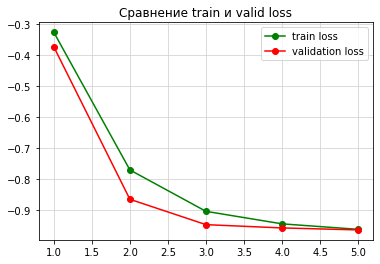

In [205]:
plt.plot(np.arange(1, 6), epoch_losses, 'go-', label='train loss')
plt.plot(np.arange(1, 6), epoch_val_losses, 'ro-', label='validation loss')

plt.legend(loc="upper right")
plt.grid(color="lightgrey")
plt.title('Сравнение train и valid loss' )
plt.show()

In [206]:
net_out = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
net_out.load_state_dict(torch.load(path_checkpoint + f"/checkpoint_lp_ep_5.pth"))

<All keys matched successfully>

C:\Users\Busi\anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


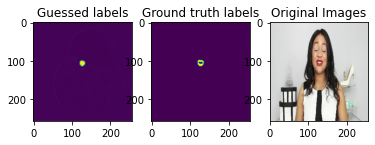

C:\Users\Busi\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

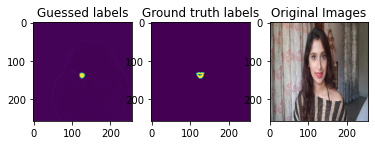

<Figure size 432x288 with 0 Axes>

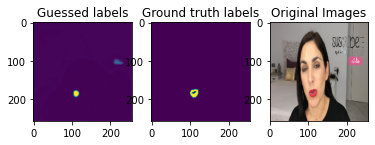

<Figure size 432x288 with 0 Axes>

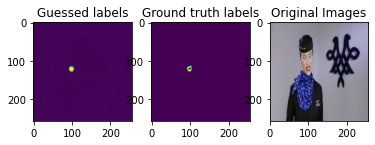

<Figure size 432x288 with 0 Axes>

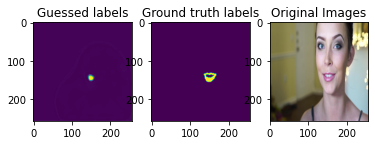

<Figure size 432x288 with 0 Axes>

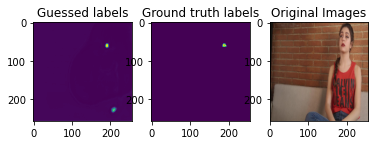

<Figure size 432x288 with 0 Axes>

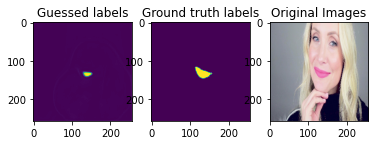

<Figure size 432x288 with 0 Axes>

In [207]:
%matplotlib inline

for i, data in enumerate(valid_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net_out(images[0])
    f, axarr = plt.subplots(1,3)

    # axarr[0].imshow(torch.argmax(outputs[0].detach().cpu().numpy()[1,:,:]))
    axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = images[0][0,:,:,:].cpu()
    original = original.permute(1, 2, 0)
    original = original.numpy()
    original = np.clip(original, 0, 1)
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

#### 3.	*(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.